In [5]:
import pytz
import requests
import bs4
from bs4 import BeautifulSoup
from time import sleep
import pandas as pd
import numpy as np
import h5py
from io import BytesIO
import zipfile
import sys
import random
import pickle
import ENTSOE
import psycopg2 as pg
import sqlalchemy as sq
def get_connection():
    '''
    FUNCTION TO CONNECT TO THE POSTGRESQL DATABASE AND RETURN THE SQLACHEMY ENGINE OBJECT
    -----------
    output: object
        SQLACHEMY ENGINE OBJECT - POSTGRESQL DATABASE CONNECTION
    '''
    user = 'postgres'
    password = 123
    host = 'localhost'
    port = 5432
    database = 'postgres'
    return sq.create_engine(url="postgresql://{0}:{1}@{2}:{3}/{4}".format(user, password, host, port, database))

DOMAIN_MAPPINGS = {
    'AL': '10YAL-KESH-----5',
    'AT': '10YAT-APG------L',
    'BA': '10YBA-JPCC-----D',
    'BE': '10YBE----------2',
    'BG': '10YCA-BULGARIA-R',
    'BY': '10Y1001A1001A51S',
    'CH': '10YCH-SWISSGRIDZ',
    'CZ': '10YCZ-CEPS-----N',
    'DE': '10Y1001A1001A83F',
    'DEp': '10Y1001A1001A63L',
    'DK': '10Y1001A1001A65H',
    'EE': '10Y1001A1001A39I',
    'ES': '10YES-REE------0',
    'FI': '10YFI-1--------U',
    'FR': '10YFR-RTE------C',
    'GB': '10YGB----------A',
    'GB-NIR': '10Y1001A1001A016',
    'GR': '10YGR-HTSO-----Y',
    'HR': '10YHR-HEP------M',
    'HU': '10YHU-MAVIR----U',
    'IE': '10YIE-1001A00010',
    'IT': '10YIT-GRTN-----B',
    'LT': '10YLT-1001A0008Q',
    'LU': '10YLU-CEGEDEL-NQ',
    'LV': '10YLV-1001A00074',
    # 'MD': 'MD',
    'ME': '10YCS-CG-TSO---S',
    'MK': '10YMK-MEPSO----8',
    'MT': '10Y1001A1001A93C',
    'NL': '10YNL----------L',
    'NO': '10YNO-0--------C',
    'PL': '10YPL-AREA-----S',
    'PT': '10YPT-REN------W',
    'RO': '10YRO-TEL------P',
    'RS': '10YCS-SERBIATSOV',
    'RU': '10Y1001A1001A49F',
    'RU-KGD': '10Y1001A1001A50U',
    'SE': '10YSE-1--------K',
    'SI': '10YSI-ELES-----O',
    'SK': '10YSK-SEPS-----K',
    'TR': '10YTR-TEIAS----W',
    'UA': '10YUA-WEPS-----0'
}

BIDDING_ZONES = DOMAIN_MAPPINGS.copy()
BIDDING_ZONES.update({
    'DE': '10Y1001A1001A63L',  # DE-AT-LU
    'LU': '10Y1001A1001A63L',  # DE-AT-LU
    'IT-NORD': '10Y1001A1001A73I',
    'IT-CNOR': '10Y1001A1001A70O',
    'IT-CSUD': '10Y1001A1001A71M',
    'IT-SUD': '10Y1001A1001A788',
    'IT-FOGN': '10Y1001A1001A72K',
    'IT-ROSN': '10Y1001A1001A77A',
    'IT-BRNN': '10Y1001A1001A699',
    'IT-PRGP': '10Y1001A1001A76C',
    'IT-SARD': '10Y1001A1001A74G',
    'IT-SICI': '10Y1001A1001A75E',
    'NO-1': '10YNO-1--------2',
    'NO-2': '10YNO-2--------T',
    'NO-3': '10YNO-3--------J',
    'NO-4': '10YNO-4--------9',
    'NO-5': '10Y1001A1001A48H',
    'SE-1': '10Y1001A1001A44P',
    'SE-2': '10Y1001A1001A45N',
    'SE-3': '10Y1001A1001A46L',
    'SE-4': '10Y1001A1001A47J',
    'DK-1': '10YDK-1--------W',
    'DK-2': '10YDK-2--------M'
})

TIMEZONE_MAPPINGS = {
    'AL': 'Europe/Tirane',
    'AT': 'Europe/Vienna',
    'BA': 'Europe/Sarajevo',
    'BE': 'Europe/Brussels',
    'BG': 'Europe/Sofia',
    'BY': 'Europe/Minsk',
    'CH': 'Europe/Zurich',
    'CZ': 'Europe/Prague',
    'DE': 'Europe/Berlin',
    'DEp': 'Europe/Berlin',
    'DK': 'Europe/Copenhagen',
    'EE': 'Europe/Talinn',
    'ES': 'Europe/Madrid',
    'FI': 'Europe/Helsinki',
    'FR': 'Europe/Paris',
    'GB': 'Europe/London',
    'GB-NIR': 'Europe/Belfast',
    'GR': 'Europe/Athens',
    'HR': 'Europe/Zagreb',
    'HU': 'Europe/Budapest',
    'IE': 'Europe/Dublin',
    'IT': 'Europe/Rome',
    'LT': 'Europe/Vilnius',
    'LU': 'Europe/Luxembourg',
    'LV': 'Europe/Riga',
    # 'MD': 'MD',
    'ME': 'Europe/Podgorica',
    'MK': 'Europe/Skopje',
    'MT': 'Europe/Malta',
    'NL': 'Europe/Amsterdam',
    'NO': 'Europe/Oslo',
    'PL': 'Europe/Warsaw',
    'PT': 'Europe/Lisbon',
    'RO': 'Europe/Bucharest',
    'RS': 'Europe/Belgrade',
    'RU': 'Europe/Moscow',
    'RU-KGD': 'Europe/Kaliningrad',
    'SE': 'Europe/Stockholm',
    'SI': 'Europe/Ljubljana',
    'SK': 'Europe/Bratislava',
    'TR': 'Europe/Istanbul',
    'UA': 'Europe/Kiev'
}

PSRTYPE_MAPPINGS = {
    'A03': 'Mixed',
    'A04': 'Generation',
    'A05': 'Load',
    'B01': 'Biomass',
    'B02': 'Fossil Brown coal/Lignite',
    'B03': 'Fossil Coal-derived gas',
    'B04': 'Fossil Gas',
    'B05': 'Fossil Hard coal',
    'B06': 'Fossil Oil',
    'B07': 'Fossil Oil shale',
    'B08': 'Fossil Peat',
    'B09': 'Geothermal',
    'B10': 'Hydro Pumped Storage',
    'B11': 'Hydro Run-of-river and poundage',
    'B12': 'Hydro Water Reservoir',
    'B13': 'Marine',
    'B14': 'Nuclear',
    'B15': 'Other renewable',
    'B16': 'Solar',
    'B17': 'Waste',
    'B18': 'Wind Offshore',
    'B19': 'Wind Onshore',
    'B20': 'Other',
    'B21': 'AC Link',
    'B22': 'DC Link',
    'B23': 'Substation',
    'B24': 'Transformer'}

DOCSTATUS = {'A05': 'Active', 'A09': 'Cancelled', 'A13': 'Withdrawn'}

BSNTYPE = {'A29': 'Already allocated capacity (AAC)',
           'A43': 'Requested capacity (without price)',
           'A46': 'System Operator redispatching',
           'A53': 'Planned maintenance',
           'A54': 'Unplanned outage',
           'A85': 'Internal redispatch',
           'A95': 'Frequency containment reserve',
           'A96': 'Automatic frequency restoration reserve',
           'A97': 'Manual frequency restoration reserve',
           'A98': 'Replacement reserve',
           'B01': 'Interconnector network evolution',
           'B02': 'Interconnector network dismantling',
           'B03': 'Counter trade',
           'B04': 'Congestion costs',
           'B05': 'Capacity allocated (including price)',
           'B07': 'Auction revenue',
           'B08': 'Total nominated capacity',
           'B09': 'Net position',
           'B10': 'Congestion income',
           'B11': 'Production unit'}

DOCUMENTTYPE = {'A09': 'Finalised schedule',
                'A11': 'Aggregated energy data report',
                'A25': 'Allocation result document',
                'A26': 'Capacity document',
                'A31': 'Agreed capacity',
                'A44': 'Price Document',
                'A61': 'Estimated Net Transfer Capacity',
                'A63': 'Redispatch notice',
                'A65': 'System total load',
                'A68': 'Installed generation per type',
                'A69': 'Wind and solar forecast',
                'A70': 'Load forecast margin',
                'A71': 'Generation forecast',
                'A72': 'Reservoir filling information',
                'A73': 'Actual generation',
                'A74': 'Wind and solar generation',
                'A75': 'Actual generation per type',
                'A76': 'Load unavailability',
                'A77': 'Production unavailability',
                'A78': 'Transmission unavailability',
                'A79': 'Offshore grid infrastructure unavailability',
                'A80': 'Generation unavailability',
                'A81': 'Contracted reserves',
                'A82': 'Accepted offers',
                'A83': 'Activated balancing quantities',
                'A84': 'Activated balancing prices',
                'A85': 'Imbalance prices',
                'A86': 'Imbalance volume',
                'A87': 'Financial situation',
                'A88': 'Cross border balancing',
                'A89': 'Contracted reserve prices',
                'A90': 'Interconnection network expansion',
                'A91': 'Counter trade notice',
                'A92': 'Congestion costs',
                'A93': 'DC link capacity',
                'A94': 'Non EU allocations',
                'A95': 'Configuration document',
                'B11': 'Flow-based allocations'}

def _extract_timeseries(xml_text):
    """
    Parameters
    ----------
    xml_text : str
    Yields
    -------
    bs4.element.tag
    """
    if not xml_text:
        return
    soup = bs4.BeautifulSoup(xml_text, 'html.parser')
    for timeseries in soup.find_all('timeseries'):
        yield timeseries

def _parse_generation_forecast_timeseries(soup):
    """
    Parameters
    ----------
    soup : bs4.element.tag
    Returns
    -------
    pd.Series
    """
    psrtype = soup.find('psrtype').text
    positions = []
    quantities = []
    for point in soup.find_all('point'):
        positions.append(int(point.find('position').text))
        quantities.append(float(point.find('quantity').text))

    series = pd.Series(index=positions, data=quantities)
    series = series.sort_index()
    series.index = _parse_datetimeindex(soup)

    series.name = PSRTYPE_MAPPINGS[psrtype]
    return series

def _parse_datetimeindex(soup):
    """
    Create a datetimeindex from a parsed beautifulsoup,
    given that it contains the elements 'start', 'end'
    and 'resolution'
    Parameters
    ----------
    soup : bs4.element.tag
    Returns
    -------
    pd.DatetimeIndex
    """
    start = pd.Timestamp(soup.find('start').text)
    end = pd.Timestamp(soup.find('end').text)
    delta = _resolution_to_timedelta(res_text=soup.find('resolution').text)
    index = pd.date_range(start=start, end=end, freq=delta, closed='left')
    return index

def _resolution_to_timedelta(res_text: str) -> str:
    """
    Convert an Entsoe resolution to something that pandas can understand
    """
    resolutions = {
        'PT60M': '60min',
        'P1Y': '12M',
        'PT15M': '15min',
        'PT30M': '30min'
    }
    delta = resolutions.get(res_text)
    if delta is None:
        raise NotImplementedError("Sorry, I don't know what to do with the "
                                  "resolution '{}', because there was no "
                                  "documentation to be found of this format. "
                                  "Everything is hard coded. Please open an "
                                  "issue.".format(res_text))
    return delta

def data_arrange(generation):
    data_table = generation

    set_columns = generation.columns
    set_gen = ['Fossil Brown coal/Lignite', 'Fossil Coal-derived gas', 'Fossil Gas', 'Fossil Hard coal', 'Fossil Oil',
               'Fossil Oil shale', 'Fossil Peat', 'Geothermal', 'Hydro Pumped Storage', 'Hydro Run-of-river and poundage',
               'Hydro Water Reservoir', 'Marine', 'Nuclear', 'Other renewable', 'Solar', 'Waste', 'Wind Offshore', 'Wind Onshore', 'Other', 'Biomass']

    for kind in set_gen:
        if not kind in set_columns:
            data_table[kind] = [0]*(data_table.shape[0])
    
    EFt = (71*data_table['Biomass']+800*(data_table['Fossil Hard coal'] + data_table['Fossil Coal-derived gas']) +400*data_table['Fossil Gas']+520*data_table['Fossil Oil']+520*data_table['Fossil Oil shale'] + 376*data_table['Fossil Peat'] + 45*data_table['Geothermal']+ 34*data_table['Hydro Pumped Storage'] + 4*data_table['Hydro Run-of-river and poundage']+
    9.0*data_table['Hydro Water Reservoir']+  820*data_table['Fossil Brown coal/Lignite'] + 376*data_table['Marine'] + 11*data_table['Nuclear'] + 43*data_table['Solar'] + 690*data_table['Waste'] + 
    9*data_table['Wind Offshore'] + 8*data_table['Wind Onshore']+ 33*data_table['Other renewable'] + 376*data_table['Other'])/(data_table.sum(axis=1))

    return EFt

def _datetime_to_str(dtm):
    """
    Convert a datetime object to a string in UTC
    of the form YYYYMMDDhh00
    Parameters
    ----------
    dtm : pd.Timestamp
        Recommended to use a timezone-aware object!
        If timezone-naive, UTC is assumed
    Returns
    -------
    str
    """
    if dtm.tzinfo is not None and dtm.tzinfo != pytz.UTC:
        dtm = dtm.tz_convert("UTC")
    fmt = '%Y%m%d%H00'
    ret_str = dtm.strftime(fmt)
    return ret_str

def base_request(params,api_key,start,end):
    start_str = _datetime_to_str(start)
    end_str = _datetime_to_str(end)
    base_params = {
        'securityToken': api_key,
        'periodStart': start_str,
        'periodEnd': end_str
    }
    params.update(base_params)
    retry_count = 100
    session = requests.Session()
    error = None
    for _ in range(retry_count):
        response = session.get(url=URL,params=params)
        try:
            response.raise_for_status()
        except requests.HTTPError as e:
            error = e
            soup = BeautifulSoup(response.text,'html.parser')
            text = soup.find_all('text')
            if len(text):
                error_text = soup.find('text').text
                if 'No matching data found' in error_text:
                    return None
            retry_delay = random.randint(1,180)
            print("HTTP Error, retrying in {} seconds".format(retry_delay))
            sleep(retry_delay)
        else:
            return response
    else:
        raise error

In [6]:
from datetime import date, datetime, timedelta
from tqdm import tqdm
import numpy as np
def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta
days=[]
for result in tqdm(perdelta(date(2019,1, 1), date(2022, 1, 1), timedelta(days=1))):
    today=str(result)
    today=today.replace('-','/')
    t2=today
    if today[5] == '0':
        t2=str(t2[0:5])+str(t2[6:])
        if today[8] == '0':
            t2=str(t2[0:7])+str(t2[8:])
    if today[8] == '0':
        t2=str(t2[0:8])+str(t2[9:])
    days.append(t2)

1096it [00:00, 549809.49it/s]


In [7]:
paises = ['Alemanha', 'Portugal', 'Espanha', 'Belgica']
codigos = ['DE', 'PT','ES', 'BE']
for p in range(len(paises)):
    pais = paises[p]
    cod = codigos[p]
    datatotal= pd.DataFrame()
    for d in tqdm(range(len(days)-1)):
        key = '22315e8f-fd66-40be-8d19-f33011dfb52f' #key Talysson Santos
        """until 25 march inc, put the desired date and +01:00; otherwise +02:00, until october 28 inc. SKIP 26/03 and 29/10"""
        #query = ENTSOE.Entsoe('747061e5-91e4-4fc5-a722-659f33b144b6') #my key
        datelist_start = pd.date_range(start=days[d]+str(' ')+str('00:00:00 +01:00'),end=days[d+1]+str(' ')+str('23:45:00 +01:00'),freq='D',name='datelist_start')
        #period of interest. it cannot be too long, otherwise it will give you an error
        filename = "dados/Data_2019_2021"+str(pais)

        realized = pd.DataFrame()
        generation = pd.DataFrame()
        emission = pd.DataFrame()
        #session = requests.Session()
        URL = 'https://transparency.entsoe.eu/api'
        #print("\n")
        query = ENTSOE.Entsoe('22315e8f-fd66-40be-8d19-f33011dfb52f') #my key
        """until 25 march inc, put the desired date and +01:00; otherwise +02:00, until october 28 inc. SKIP 26/03 and 29/10"""
        consumption = []
        #for k in datelist_start:
        k=datelist_start[0]
        #query.query_generation('DE',k,k+pd.DateOffset(hours=24),True) #country; split data every 24hours; parse the data
        country_code = cod
        start = k
        end = k+pd.DateOffset(hours=24)
        '''params = {
            'documentType': 'A75',
            'processType': 'A16',
            'in_Domain': DOMAIN_MAPPINGS[country_code],
            'securityToken': key,
            'periodStart': start_str,
            'periodEnd': end_str
        }'''
        params = {
            'documentType': 'A75',
            'processType': 'A16',
            'in_Domain': DOMAIN_MAPPINGS[country_code],
        }
        #response = session.get(url=URL, params=params)
        var = False
        while var == False:
            try:
                response = base_request(params,key,start,end)
                var = True
            except:
                var = False

        #print("\n"+response.text+"\n")
        #if response is None:
        #    print("Resposta é None")
        all_series = {}
        for soup in _extract_timeseries(response.text):
            ts = _parse_generation_forecast_timeseries(soup)
            series = all_series.get(ts.name)
            if series is None:
                all_series[ts.name] = ts
            else:
                series = series.append(ts)
                series.sort_index()
                all_series[series.name] = series

        for name in all_series:
            ts = all_series[name]
            all_series[name] = ts[~ts.index.duplicated(keep='first')]

        gen_all = pd.DataFrame.from_dict(all_series)
        gen_all = gen_all.tz_convert(TIMEZONE_MAPPINGS[country_code])
        production = gen_all
        #print("\n"+str(production.shape[0])+"\n")
        EF = data_arrange(production)   #calculate emission factors
        gen_all = gen_all.resample('60T').mean()
        EF = EF.resample('60T').mean()
        generation = generation.append(gen_all)

        emission = emission.append(pd.DataFrame(EF,columns=['Emission']))
        query.query_consumption(cod, k, k + pd.DateOffset(hours = 24), True)
        load = query.load.resample('60T').mean()
        t=load.to_list()
        consumption.extend(t)

        #gen_sum = gen_all.sum(axis='columns') #total generation
        #print(".",end="")
        #sys.stdout.flush()
        generation.insert(20, "Emission",emission['Emission'], True) 
        generation['Consumption']=consumption
        datatotal=datatotal.append(generation)
    out_file = open(filename+".pickle",'wb')
    datatotal['Date']=datatotal.index.strftime("%Y/%m/%d")
    datatotal['Hour']=datatotal.index.strftime("%H:%M")
    datatotal['UTC']=datatotal.index.strftime("%z")
    datatotal = datatotal.reset_index(drop = True)
    pickle.dump(datatotal,out_file)
    out_file.close()
    datatotal.to_sql(name=str.lower(pais), con = get_connection(),schema = 'original_data', if_exists = 'replace', chunksize = None, index = False)
    print("TERMINOU")

100%|████████████████████████████████████████████████████████████████████████████| 1095/1095 [1:10:45<00:00,  3.88s/it]


TERMINOU


100%|██████████████████████████████████████████████████████████████████████████████| 1095/1095 [52:26<00:00,  2.87s/it]


TERMINOU


100%|██████████████████████████████████████████████████████████████████████████████| 1095/1095 [56:14<00:00,  3.08s/it]


TERMINOU


100%|██████████████████████████████████████████████████████████████████████████████| 1095/1095 [51:08<00:00,  2.80s/it]


TERMINOU


In [13]:
datatotal[datatotal['Date']=='2021/12/30']

,Biomass,Fossil Gas,Fossil Hard coal,Fossil Oil,Hydro Pumped Storage,Hydro Run-of-river and poundage,Nuclear,Other,Solar,Waste,...,Fossil Peat,Geothermal,Hydro Water Reservoir,Marine,Other renewable,Emission,Consumption,Date,Hour,UTC
26256,238.0,675.0,0.0,0.0,411.0,5.0,5965.0,0.0,0.0,159.0,...,0.0,0.0,0.0,0.0,0.0,47.780659,8201.00,2021/12/30,00:00,+0100
26257,241.0,721.0,0.0,0.0,634.0,5.0,5959.0,0.0,0.0,156.0,...,0.0,0.0,0.0,0.0,0.0,48.785212,7779.00,2021/12/30,01:00,+0100
26258,243.0,723.0,0.0,0.0,1072.0,5.0,5958.0,0.0,0.0,156.0,...,0.0,0.0,0.0,0.0,0.0,47.620080,7599.50,2021/12/30,02:00,+0100
26259,240.0,638.0,0.0,0.0,1069.0,5.0,5953.0,0.0,0.0,157.0,...,0.0,0.0,0.0,0.0,0.0,44.330105,7484.25,2021/12/30,03:00,+0100
26260,171.0,656.0,0.0,0.0,1146.0,5.0,5948.0,0.0,0.0,157.0,...,0.0,0.0,0.0,0.0,0.0,45.126694,7384.00,2021/12/30,04:00,+0100
26261,123.0,660.0,0.0,0.0,1095.0,5.0,5947.0,0.0,0.0,158.0,...,0.0,0.0,0.0,0.0,0.0,45.618713,7638.75,2021/12/30,05:00,+0100
26262,188.0,717.0,0.0,0.0,156.0,5.0,5952.0,0.0,0.0,155.0,...,0.0,0.0,0.0,0.0,0.0,47.454308,8243.00,2021/12/30,06:00,+0100
26263,243.0,665.0,0.0,0.0,102.0,5.0,5955.0,0.0,0.0,152.0,...,0.0,0.0,0.0,0.0,0.0,45.537327,8733.00,2021/12/30,07:00,+0100
26264,244.0,687.0,0.0,0.0,542.0,6.0,5955.0,0.0,0.0,150.0,...,0.0,0.0,0.0,0.0,0.0,45.525711,9143.00,2021/12/30,08:00,+0100
26265,245.0,717.0,0.0,0.0,764.0,7.0,5965.0,0.0,41.0,149.0,...,0.0,0.0,0.0,0.0,0.0,46.233165,9395.00,2021/12/30,09:00,+0100


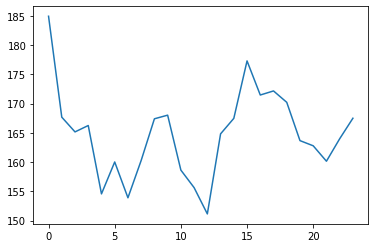

In [17]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(datatotal['Emission'])

In [24]:
all_series

{'Biomass': 2018-12-31 23:00:00+00:00    159.0
 2019-01-01 00:00:00+00:00    159.0
 2019-01-01 01:00:00+00:00    159.0
 2019-01-01 02:00:00+00:00    162.0
 2019-01-01 03:00:00+00:00    165.0
 2019-01-01 04:00:00+00:00    168.0
 2019-01-01 05:00:00+00:00    165.0
 2019-01-01 06:00:00+00:00    165.0
 2019-01-01 07:00:00+00:00    163.0
 2019-01-01 08:00:00+00:00    163.0
 2019-01-01 09:00:00+00:00    167.0
 2019-01-01 10:00:00+00:00    165.0
 2019-01-01 11:00:00+00:00    168.0
 2019-01-01 12:00:00+00:00    169.0
 2019-01-01 13:00:00+00:00    156.0
 2019-01-01 14:00:00+00:00    156.0
 2019-01-01 15:00:00+00:00    153.0
 2019-01-01 16:00:00+00:00    153.0
 2019-01-01 17:00:00+00:00    156.0
 2019-01-01 18:00:00+00:00    153.0
 2019-01-01 19:00:00+00:00    153.0
 2019-01-01 20:00:00+00:00    152.0
 2019-01-01 21:00:00+00:00    155.0
 2019-01-01 22:00:00+00:00    158.0
 Freq: 60T, Name: Biomass, dtype: float64,
 'Fossil Gas': 2018-12-31 23:00:00+00:00    1920.0
 2019-01-01 00:00:00+00:00    1

In [19]:
datatotal.head()

,Biomass,Fossil Brown coal/Lignite,Fossil Gas,Fossil Hard coal,Fossil Oil,Geothermal,Hydro Pumped Storage,Hydro Run-of-river and poundage,Hydro Water Reservoir,Nuclear,...,Wind Onshore,Fossil Coal-derived gas,Fossil Oil shale,Fossil Peat,Marine,Emission,Consumption,Date,Hour,UTC
0,159.0,0,1920.0,0.0,0.0,0,66.0,38.0,0,2376.0,...,272.0,0,0,0,0,184.925193,8973.25,2019/01/01,00:00,+0100
1,159.0,0,1637.0,0.0,0.0,0,347.0,39.0,0,2376.0,...,305.0,0,0,0,0,167.678742,8542.75,2019/01/01,01:00,+0100
2,159.0,0,1587.0,0.0,0.0,0,298.0,40.0,0,2383.0,...,292.0,0,0,0,0,165.159278,8077.50,2019/01/01,02:00,+0100
3,162.0,0,1598.0,0.0,0.0,0,197.0,39.0,0,2413.0,...,343.0,0,0,0,0,166.251426,7823.25,2019/01/01,03:00,+0100
4,165.0,0,1535.0,0.0,0.0,0,478.0,37.0,0,2416.0,...,392.0,0,0,0,0,154.567410,7636.25,2019/01/01,04:00,+0100


In [8]:
from datetime import datetime
datatotal['Date']

2019-01-01 00:00:00+01:00    2019/01/01
2019-01-01 00:15:00+01:00    2019/01/01
2019-01-01 00:30:00+01:00    2019/01/01
2019-01-01 00:45:00+01:00    2019/01/01
2019-01-01 01:00:00+01:00    2019/01/01
                                ...    
2020-12-30 22:45:00+01:00    2020/12/30
2020-12-30 23:00:00+01:00    2020/12/30
2020-12-30 23:15:00+01:00    2020/12/30
2020-12-30 23:30:00+01:00    2020/12/30
2020-12-30 23:45:00+01:00    2020/12/30
Name: Date, Length: 70080, dtype: object

In [33]:
import pickle
dados = pickle.load(open("Data_2019_2020.pickle", "rb" ))

In [12]:
data = []
for i in dados['Date']:
    if i not in data:
        data.append(i)

In [13]:
daysNan = []
dayscomplete = []
dadoscomplete = pd.DataFrame(columns=dados.columns)
for h in data:
    daydata=dados[(dados['Date']==h)].reset_index(drop=True)
    for i in daydata.columns:
        for j in daydata[i]:
            if j != j or j=='nan' or j=='Nan' or j=='NaN' or len(daydata)!=96:
                daysNan.append(h)
                break
    if h not in daysNan:
        dayscomplete.append(h)
        dadoscomplete=dadoscomplete.append(daydata)
daysNan=list(set(daysNan))  
daysNan.sort()
print('Número de dias com dados faltantes:',len(daysNan))
print('Número de dias com dados completos:',len(dayscomplete))

Número de dias com dados faltantes: 5
Número de dias com dados completos: 725


In [14]:
daysNan

['2019/03/31', '2019/10/11', '2019/10/27', '2020/03/29', '2020/10/25']

In [19]:
list_source = []
for i in dadoscomplete.columns:
    if i not in ['Emission', 'Consumption', 'Date', 'Hour']:
        list_source.append(i)
dadoscomplete['Generation'] = dadoscomplete.loc[:,list_source].sum(axis=1)

In [20]:
dadoscomplete.head()

,Biomass,Fossil Brown coal/Lignite,Fossil Gas,Fossil Hard coal,Fossil Oil,Geothermal,Hydro Pumped Storage,Hydro Run-of-river and poundage,Hydro Water Reservoir,Nuclear,...,Fossil Coal-derived gas,Fossil Oil shale,Fossil Peat,Marine,Emission,Consumption,Date,Hour,UTC,Generation
0,4926.0,6932.0,3402.0,3345.0,482.0,19.0,118.0,1472.0,132.0,9002.0,...,0,0,0,0,208.671811,43671.0,2019/01/01,00:00,+0100,53003.0
1,4937.0,6351.0,3286.0,2918.0,484.0,19.0,320.0,1471.0,108.0,9053.0,...,0,0,0,0,193.065068,43195.0,2019/01/01,00:15,+0100,52852.0
2,4926.0,6221.0,3219.0,2594.0,481.0,19.0,116.0,1470.0,55.0,8984.0,...,0,0,0,0,186.139291,42704.0,2019/01/01,00:30,+0100,52717.0
3,4934.0,5836.0,3186.0,2390.0,482.0,19.0,117.0,1472.0,52.0,8967.0,...,0,0,0,0,178.519102,42481.0,2019/01/01,00:45,+0100,52221.0
4,4916.0,5471.0,3062.0,2442.0,483.0,19.0,116.0,1478.0,75.0,8898.0,...,0,0,0,0,173.330461,42139.0,2019/01/01,01:00,+0100,51991.0


In [38]:
dadoscomplete = dadoscomplete.reset_index(drop=True)
out_file = open(filename+"complete.pickle",'wb')

pickle.dump(dadoscomplete,out_file)

In [39]:
import pickle
teste = pickle.load(open(filename+"complete.pickle", 'rb' ))

In [40]:
teste

,Biomass,Fossil Brown coal/Lignite,Fossil Gas,Fossil Hard coal,Fossil Oil,Geothermal,Hydro Pumped Storage,Hydro Run-of-river and poundage,Hydro Water Reservoir,Nuclear,...,Fossil Coal-derived gas,Fossil Oil shale,Fossil Peat,Marine,Emission,Consumption,Date,Hour,UTC,Generation
0,4926.0,6932.0,3402.0,3345.0,482.0,19.0,118.0,1472.0,132.0,9002.0,...,0,0,0,0,208.671811,43671.0,2019/01/01,00:00,+0100,53003.0
1,4937.0,6351.0,3286.0,2918.0,484.0,19.0,320.0,1471.0,108.0,9053.0,...,0,0,0,0,193.065068,43195.0,2019/01/01,00:15,+0100,52852.0
2,4926.0,6221.0,3219.0,2594.0,481.0,19.0,116.0,1470.0,55.0,8984.0,...,0,0,0,0,186.139291,42704.0,2019/01/01,00:30,+0100,52717.0
3,4934.0,5836.0,3186.0,2390.0,482.0,19.0,117.0,1472.0,52.0,8967.0,...,0,0,0,0,178.519102,42481.0,2019/01/01,00:45,+0100,52221.0
4,4916.0,5471.0,3062.0,2442.0,483.0,19.0,116.0,1478.0,75.0,8898.0,...,0,0,0,0,173.330461,42139.0,2019/01/01,01:00,+0100,51991.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69595,4624.0,8279.0,5723.0,3591.0,409.0,30.0,300.0,1212.0,26.0,7674.0,...,0,0,0,0,244.799388,49821.0,2020/12/30,22:45,+0100,54234.0
69596,4628.0,8642.0,5270.0,3556.0,407.0,30.0,776.0,1207.0,102.0,7614.0,...,0,0,0,0,245.189355,49114.0,2020/12/30,23:00,+0100,54559.0
69597,4616.0,8645.0,5199.0,3477.0,406.0,30.0,629.0,1206.0,58.0,7610.0,...,0,0,0,0,244.750069,48440.0,2020/12/30,23:15,+0100,54287.0
69598,4625.0,8687.0,5164.0,3376.0,406.0,30.0,187.0,1204.0,21.0,7610.0,...,0,0,0,0,246.475662,47699.0,2020/12/30,23:30,+0100,53578.0


In [4]:
import numpy as np
np.mean([71,43,8,9,45,34,4,9,11,820,800,800,400,520,690])

284.26666666666665